In [392]:
import pandas as pd
import numpy as np
import bisect
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.options.mode.chained_assignment = None  # default='warn'

In [393]:
def read_dataset():
    """

    :return: Complete dataset
    """
    df = pd.read_csv('Glucose_measurements_sample.csv',
                     dtype={'Glucose_measurements': int})
    add_features(df)

    return df


def add_features(df):
    """

    :param df:
    :return: Add a unify temporal and date column
    """
    df["Time"] = pd.to_datetime(df["Measurement_date"] + ' '
                                + df["Measurement_time"])


def get_patient_ids(df=None):
    """

    :param df_glucose:
    :return: List of patient ids
    """
    if df is None:
        df = read_dataset()
    return df['Patient_ID'].unique()


def get_patient_data_df(patient_id, df=None):
    """

    :param patient_id:
    :param df:
    :return: All data of a patient
    """
    if df is None:
        df = read_dataset()
    return df[df['Patient_ID'] == patient_id]


### Preprocessing
# Return a dataset with lagged col of df and the difference
def get_lagged_col(df, col, new_col_name, diff_name, diff_time_treatment=False,
                   absolute_value=False):
    """
    :param df: Dataframe to lagg, if not all dataset
    :param col: Column to lag
    :param new_col_name: New name of lagged column
    :param diff_name: Name of diff column
    :param diff_time_treatment: Time difference treatment
    :param absolute_value: If true abs value diff
    :return: A df with three columns: col, col-1 and difference


    """
    df[f"{new_col_name}-1"] = df.groupby(['Patient_ID'])[col].shift(1)
    df = df.rename(columns={col: new_col_name})

    # Create diff col
    df[diff_name] = df[new_col_name] - df[f"{new_col_name}-1"]
    if absolute_value:
        df[diff_name] = abs(df[diff_name])
    if diff_time_treatment:
        df[diff_name] = df[diff_name] / np.timedelta64(1, 'm')

    return df


def find_date_position(dates_list, date):
    """

    :param dates_list:
    :param date:
    :return: Position + 1 of date in ordered dates_list
    """
    return bisect.bisect_right(dates_list, date)


def add_col_split_gaps(df, threshold, diff_col, conditional_col):
    """

    :param df:
    :param threshold:
    :param diff_col:
    :param conditional_col:
    :return: Add an index that represents the split portion for df
    based on threshold applied to diff_col
    """
    gaps = df[df[diff_col] > threshold]
    gaps_date = gaps[conditional_col].to_list()

    df["split"] = df[conditional_col].apply(lambda date: find_date_position(gaps_date, date))


def update_lag_cols(df):
    '''

    :param df:
    :return: df with updated lag columns and diffs
    '''
    # Updating diff cols
    df.drop('Minutes_diff', inplace=True, axis=1)
    df.drop('t-1', inplace=True, axis=1)
    df.drop('Measurement_diff', inplace=True, axis=1)
    df.drop('Measurement-1', inplace=True, axis=1)
    df_lag = get_lagged_col(df=df, col="t", new_col_name="t",
                            diff_time_treatment=True, diff_name="Minutes_diff")
    df_lag = get_lagged_col(df=df_lag, col="Measurement", new_col_name="Measurement",
                            absolute_value=True, diff_name="Measurement_diff")
    return df_lag


In [394]:
df_glucose = read_dataset()
df_glucose_lag = get_lagged_col(df=df_glucose, col="Time", new_col_name="t",
                           diff_time_treatment=True, diff_name="Minutes_diff")
df_glucose_lag = get_lagged_col(df=df_glucose_lag, col="Measurement", new_col_name="Measurement",
                                absolute_value=True, diff_name="Measurement_diff")
# Removing first row (Nan) for each patient
df_glucose_lag = df_glucose_lag.dropna()

In [395]:
df_glucose_patientx = df_glucose_lag[df_glucose_lag["Patient_ID"] == 'LIB193414']
df_glucose_patientx

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
2887159,LIB193414,2022-01-11,13:55:00,157,2022-01-11 13:55:00,2022-01-11 13:40:00,15.000000,159.000000,2.000000
2887160,LIB193414,2022-01-11,14:10:00,161,2022-01-11 14:10:00,2022-01-11 13:55:00,15.000000,157.000000,4.000000
2887161,LIB193414,2022-01-11,14:25:00,157,2022-01-11 14:25:00,2022-01-11 14:10:00,15.000000,161.000000,4.000000
2887162,LIB193414,2022-01-11,14:40:00,152,2022-01-11 14:40:00,2022-01-11 14:25:00,15.000000,157.000000,5.000000
2887163,LIB193414,2022-01-11,14:55:00,158,2022-01-11 14:55:00,2022-01-11 14:40:00,15.000000,152.000000,6.000000
...,...,...,...,...,...,...,...,...,...
2888741,LIB193414,2022-01-28,10:37:00,126,2022-01-28 10:37:00,2022-01-28 10:22:00,15.000000,127.000000,1.000000
2888742,LIB193414,2022-01-28,10:52:00,114,2022-01-28 10:52:00,2022-01-28 10:37:00,15.000000,126.000000,12.000000
2888743,LIB193414,2022-01-28,11:08:00,95,2022-01-28 11:08:00,2022-01-28 10:52:00,16.000000,114.000000,19.000000
2888744,LIB193414,2022-01-28,11:23:00,92,2022-01-28 11:23:00,2022-01-28 11:08:00,15.000000,95.000000,3.000000


In [396]:
# About the last days of measurements added to another df and removed
df_glucose_patientx_test = df_glucose_patientx.tail(46)
df_glucose_patientx_test


,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
2888700,LIB193414,2022-01-28,00:19:00,232,2022-01-28 00:19:00,2022-01-28 00:04:00,15.000000,229.000000,3.000000
2888701,LIB193414,2022-01-28,00:34:00,233,2022-01-28 00:34:00,2022-01-28 00:19:00,15.000000,232.000000,1.000000
2888702,LIB193414,2022-01-28,00:50:00,226,2022-01-28 00:50:00,2022-01-28 00:34:00,16.000000,233.000000,7.000000
2888703,LIB193414,2022-01-28,01:05:00,209,2022-01-28 01:05:00,2022-01-28 00:50:00,15.000000,226.000000,17.000000
2888704,LIB193414,2022-01-28,01:20:00,204,2022-01-28 01:20:00,2022-01-28 01:05:00,15.000000,209.000000,5.000000
2888705,LIB193414,2022-01-28,01:35:00,198,2022-01-28 01:35:00,2022-01-28 01:20:00,15.000000,204.000000,6.000000
2888706,LIB193414,2022-01-28,01:50:00,190,2022-01-28 01:50:00,2022-01-28 01:35:00,15.000000,198.000000,8.000000
2888707,LIB193414,2022-01-28,02:05:00,182,2022-01-28 02:05:00,2022-01-28 01:50:00,15.000000,190.000000,8.000000
2888708,LIB193414,2022-01-28,02:20:00,175,2022-01-28 02:20:00,2022-01-28 02:05:00,15.000000,182.000000,7.000000
2888709,LIB193414,2022-01-28,02:35:00,168,2022-01-28 02:35:00,2022-01-28 02:20:00,15.000000,175.000000,7.000000


In [397]:

df_glucose_patientx["Measurement"].loc[df_glucose_patientx["Measurement_date"] == "2022-01-28"] = np.nan
df_glucose_patientx.at[2888745,"Measurement"] = 97
df_glucose_patientx

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
2887159,LIB193414,2022-01-11,13:55:00,157.000000,2022-01-11 13:55:00,2022-01-11 13:40:00,15.000000,159.000000,2.000000
2887160,LIB193414,2022-01-11,14:10:00,161.000000,2022-01-11 14:10:00,2022-01-11 13:55:00,15.000000,157.000000,4.000000
2887161,LIB193414,2022-01-11,14:25:00,157.000000,2022-01-11 14:25:00,2022-01-11 14:10:00,15.000000,161.000000,4.000000
2887162,LIB193414,2022-01-11,14:40:00,152.000000,2022-01-11 14:40:00,2022-01-11 14:25:00,15.000000,157.000000,5.000000
2887163,LIB193414,2022-01-11,14:55:00,158.000000,2022-01-11 14:55:00,2022-01-11 14:40:00,15.000000,152.000000,6.000000
...,...,...,...,...,...,...,...,...,...
2888741,LIB193414,2022-01-28,10:37:00,NaN,2022-01-28 10:37:00,2022-01-28 10:22:00,15.000000,127.000000,1.000000
2888742,LIB193414,2022-01-28,10:52:00,NaN,2022-01-28 10:52:00,2022-01-28 10:37:00,15.000000,126.000000,12.000000
2888743,LIB193414,2022-01-28,11:08:00,NaN,2022-01-28 11:08:00,2022-01-28 10:52:00,16.000000,114.000000,19.000000
2888744,LIB193414,2022-01-28,11:23:00,NaN,2022-01-28 11:23:00,2022-01-28 11:08:00,15.000000,95.000000,3.000000


In [398]:
df_glucose_patientx["Measurement"] = df_glucose_patientx["Measurement"].interpolate(method="polynomial", order=2)
df_glucose_patientx

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
2887159,LIB193414,2022-01-11,13:55:00,157.000000,2022-01-11 13:55:00,2022-01-11 13:40:00,15.000000,159.000000,2.000000
2887160,LIB193414,2022-01-11,14:10:00,161.000000,2022-01-11 14:10:00,2022-01-11 13:55:00,15.000000,157.000000,4.000000
2887161,LIB193414,2022-01-11,14:25:00,157.000000,2022-01-11 14:25:00,2022-01-11 14:10:00,15.000000,161.000000,4.000000
2887162,LIB193414,2022-01-11,14:40:00,152.000000,2022-01-11 14:40:00,2022-01-11 14:25:00,15.000000,157.000000,5.000000
2887163,LIB193414,2022-01-11,14:55:00,158.000000,2022-01-11 14:55:00,2022-01-11 14:40:00,15.000000,152.000000,6.000000
...,...,...,...,...,...,...,...,...,...
2888741,LIB193414,2022-01-28,10:37:00,83.531908,2022-01-28 10:37:00,2022-01-28 10:22:00,15.000000,127.000000,1.000000
2888742,LIB193414,2022-01-28,10:52:00,86.472533,2022-01-28 10:52:00,2022-01-28 10:37:00,15.000000,126.000000,12.000000
2888743,LIB193414,2022-01-28,11:08:00,89.697423,2022-01-28 11:08:00,2022-01-28 10:52:00,16.000000,114.000000,19.000000
2888744,LIB193414,2022-01-28,11:23:00,93.206579,2022-01-28 11:23:00,2022-01-28 11:08:00,15.000000,95.000000,3.000000


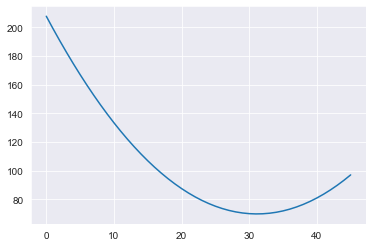

In [399]:
plt.plot(range(0,46),df_glucose_patientx["Measurement"].tail(46))

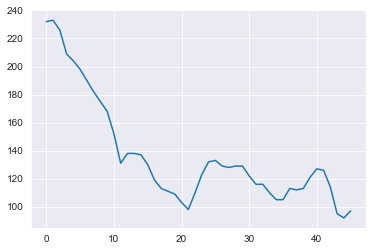

In [400]:
plt.plot(range(0,46),df_glucose_patientx_test["Measurement"].tail(46))

-----------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------------------------------

In [401]:
df_glucose_patient = df_glucose_lag[df_glucose_lag["Patient_ID"] == 'LIB193367']
df_glucose_patient

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
1914306,LIB193367,2020-01-27,19:06:00,216,2020-01-27 19:06:00,2020-01-27 18:51:00,15.000000,213.000000,3.000000
1914307,LIB193367,2020-01-27,19:22:00,207,2020-01-27 19:22:00,2020-01-27 19:06:00,16.000000,216.000000,9.000000
1914308,LIB193367,2020-01-27,19:37:00,216,2020-01-27 19:37:00,2020-01-27 19:22:00,15.000000,207.000000,9.000000
1914309,LIB193367,2020-01-27,19:52:00,222,2020-01-27 19:52:00,2020-01-27 19:37:00,15.000000,216.000000,6.000000
1914310,LIB193367,2020-01-27,20:07:00,203,2020-01-27 20:07:00,2020-01-27 19:52:00,15.000000,222.000000,19.000000
...,...,...,...,...,...,...,...,...,...
1991225,LIB193367,2022-03-15,11:46:00,283,2022-03-15 11:46:00,2022-03-15 11:31:00,15.000000,263.000000,20.000000
1991226,LIB193367,2022-03-15,12:01:00,277,2022-03-15 12:01:00,2022-03-15 11:46:00,15.000000,283.000000,6.000000
1991227,LIB193367,2022-03-15,12:16:00,240,2022-03-15 12:16:00,2022-03-15 12:01:00,15.000000,277.000000,37.000000
1991228,LIB193367,2022-03-15,12:31:00,199,2022-03-15 12:31:00,2022-03-15 12:16:00,15.000000,240.000000,41.000000


# 1 complete day

In [402]:
df_glucose_patient_24 = df_glucose_patient.copy()
df_glucose_patient_test_24 = df_glucose_patient[df_glucose_patient["Measurement_date"] == "2020-01-29"]
df_glucose_patient_test_24

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
1914421,LIB193367,2020-01-29,00:00:00,233,2020-01-29 00:00:00,2020-01-28 23:44:00,16.000000,250.000000,17.000000
1914422,LIB193367,2020-01-29,00:15:00,221,2020-01-29 00:15:00,2020-01-29 00:00:00,15.000000,233.000000,12.000000
1914423,LIB193367,2020-01-29,00:30:00,216,2020-01-29 00:30:00,2020-01-29 00:15:00,15.000000,221.000000,5.000000
1914424,LIB193367,2020-01-29,00:45:00,211,2020-01-29 00:45:00,2020-01-29 00:30:00,15.000000,216.000000,5.000000
1914425,LIB193367,2020-01-29,01:00:00,201,2020-01-29 01:00:00,2020-01-29 00:45:00,15.000000,211.000000,10.000000
...,...,...,...,...,...,...,...,...,...
1914512,LIB193367,2020-01-29,22:49:00,172,2020-01-29 22:49:00,2020-01-29 22:34:00,15.000000,156.000000,16.000000
1914513,LIB193367,2020-01-29,23:04:00,183,2020-01-29 23:04:00,2020-01-29 22:49:00,15.000000,172.000000,11.000000
1914514,LIB193367,2020-01-29,23:19:00,184,2020-01-29 23:19:00,2020-01-29 23:04:00,15.000000,183.000000,1.000000
1914515,LIB193367,2020-01-29,23:35:00,174,2020-01-29 23:35:00,2020-01-29 23:19:00,16.000000,184.000000,10.000000


In [403]:
df_glucose_patient_24["Measurement"].loc[df_glucose_patient_24["Measurement_date"] == "2020-01-29"] = np.nan
df_glucose_patient_24

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
1914306,LIB193367,2020-01-27,19:06:00,216.000000,2020-01-27 19:06:00,2020-01-27 18:51:00,15.000000,213.000000,3.000000
1914307,LIB193367,2020-01-27,19:22:00,207.000000,2020-01-27 19:22:00,2020-01-27 19:06:00,16.000000,216.000000,9.000000
1914308,LIB193367,2020-01-27,19:37:00,216.000000,2020-01-27 19:37:00,2020-01-27 19:22:00,15.000000,207.000000,9.000000
1914309,LIB193367,2020-01-27,19:52:00,222.000000,2020-01-27 19:52:00,2020-01-27 19:37:00,15.000000,216.000000,6.000000
1914310,LIB193367,2020-01-27,20:07:00,203.000000,2020-01-27 20:07:00,2020-01-27 19:52:00,15.000000,222.000000,19.000000
...,...,...,...,...,...,...,...,...,...
1991225,LIB193367,2022-03-15,11:46:00,283.000000,2022-03-15 11:46:00,2022-03-15 11:31:00,15.000000,263.000000,20.000000
1991226,LIB193367,2022-03-15,12:01:00,277.000000,2022-03-15 12:01:00,2022-03-15 11:46:00,15.000000,283.000000,6.000000
1991227,LIB193367,2022-03-15,12:16:00,240.000000,2022-03-15 12:16:00,2022-03-15 12:01:00,15.000000,277.000000,37.000000
1991228,LIB193367,2022-03-15,12:31:00,199.000000,2022-03-15 12:31:00,2022-03-15 12:16:00,15.000000,240.000000,41.000000


In [404]:
df_glucose_patient_24["Measurement"] = df_glucose_patient_24["Measurement"].interpolate(method="polynomial", order=2)
df_glucose_patient_24[df_glucose_patient_24["Measurement_date"] == "2020-01-29"]

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
1914421,LIB193367,2020-01-29,00:00:00,250.101690,2020-01-29 00:00:00,2020-01-28 23:44:00,16.000000,250.000000,17.000000
1914422,LIB193367,2020-01-29,00:15:00,250.204550,2020-01-29 00:15:00,2020-01-29 00:00:00,15.000000,233.000000,12.000000
1914423,LIB193367,2020-01-29,00:30:00,250.308581,2020-01-29 00:30:00,2020-01-29 00:15:00,15.000000,221.000000,5.000000
1914424,LIB193367,2020-01-29,00:45:00,250.413783,2020-01-29 00:45:00,2020-01-29 00:30:00,15.000000,216.000000,5.000000
1914425,LIB193367,2020-01-29,01:00:00,250.520155,2020-01-29 01:00:00,2020-01-29 00:45:00,15.000000,211.000000,10.000000
...,...,...,...,...,...,...,...,...,...
1914512,LIB193367,2020-01-29,22:49:00,170.687423,2020-01-29 22:49:00,2020-01-29 22:34:00,15.000000,156.000000,16.000000
1914513,LIB193367,2020-01-29,23:04:00,166.545389,2020-01-29 23:04:00,2020-01-29 22:49:00,15.000000,172.000000,11.000000
1914514,LIB193367,2020-01-29,23:19:00,162.305629,2020-01-29 23:19:00,2020-01-29 23:04:00,15.000000,183.000000,1.000000
1914515,LIB193367,2020-01-29,23:35:00,157.968145,2020-01-29 23:35:00,2020-01-29 23:19:00,16.000000,184.000000,10.000000


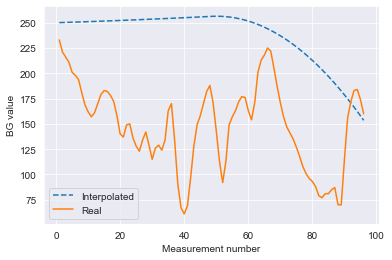

In [405]:
interpolated = df_glucose_patient_24.loc[df_glucose_patient_24["Measurement_date"] == "2020-01-29", "Measurement"]

plt.plot(range(1, interpolated.shape[0] + 1), interpolated, label = "Interpolated", linestyle="--")
plt.plot(range(1, interpolated.shape[0] + 1), df_glucose_patient_test_24["Measurement"], label = "Real")
plt.xlabel("Measurement number")
plt.ylabel("BG value")
plt.legend()
plt.show()

# 1/2 day

In [406]:
df_glucose_patient_12 = df_glucose_patient.copy()
df_glucose_patient_test_12 = \
    df_glucose_patient[(df_glucose_patient["Measurement_date"] == "2020-01-29") & (df_glucose_patient["Measurement_time"] < "12:00:00")]
df_glucose_patient_test_12


,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
1914421,LIB193367,2020-01-29,00:00:00,233,2020-01-29 00:00:00,2020-01-28 23:44:00,16.000000,250.000000,17.000000
1914422,LIB193367,2020-01-29,00:15:00,221,2020-01-29 00:15:00,2020-01-29 00:00:00,15.000000,233.000000,12.000000
1914423,LIB193367,2020-01-29,00:30:00,216,2020-01-29 00:30:00,2020-01-29 00:15:00,15.000000,221.000000,5.000000
1914424,LIB193367,2020-01-29,00:45:00,211,2020-01-29 00:45:00,2020-01-29 00:30:00,15.000000,216.000000,5.000000
1914425,LIB193367,2020-01-29,01:00:00,201,2020-01-29 01:00:00,2020-01-29 00:45:00,15.000000,211.000000,10.000000
1914426,LIB193367,2020-01-29,01:15:00,198,2020-01-29 01:15:00,2020-01-29 01:00:00,15.000000,201.000000,3.000000
1914427,LIB193367,2020-01-29,01:30:00,194,2020-01-29 01:30:00,2020-01-29 01:15:00,15.000000,198.000000,4.000000
1914428,LIB193367,2020-01-29,01:45:00,181,2020-01-29 01:45:00,2020-01-29 01:30:00,15.000000,194.000000,13.000000
1914429,LIB193367,2020-01-29,02:00:00,169,2020-01-29 02:00:00,2020-01-29 01:45:00,15.000000,181.000000,12.000000
1914430,LIB193367,2020-01-29,02:15:00,162,2020-01-29 02:15:00,2020-01-29 02:00:00,15.000000,169.000000,7.000000


In [407]:
df_glucose_patient_12["Measurement"].loc[(df_glucose_patient_12["Measurement_date"] == "2020-01-29") & (df_glucose_patient_12["Measurement_time"] < "12:00:00")] = np.nan
df_glucose_patient_12


,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
1914306,LIB193367,2020-01-27,19:06:00,216.000000,2020-01-27 19:06:00,2020-01-27 18:51:00,15.000000,213.000000,3.000000
1914307,LIB193367,2020-01-27,19:22:00,207.000000,2020-01-27 19:22:00,2020-01-27 19:06:00,16.000000,216.000000,9.000000
1914308,LIB193367,2020-01-27,19:37:00,216.000000,2020-01-27 19:37:00,2020-01-27 19:22:00,15.000000,207.000000,9.000000
1914309,LIB193367,2020-01-27,19:52:00,222.000000,2020-01-27 19:52:00,2020-01-27 19:37:00,15.000000,216.000000,6.000000
1914310,LIB193367,2020-01-27,20:07:00,203.000000,2020-01-27 20:07:00,2020-01-27 19:52:00,15.000000,222.000000,19.000000
...,...,...,...,...,...,...,...,...,...
1991225,LIB193367,2022-03-15,11:46:00,283.000000,2022-03-15 11:46:00,2022-03-15 11:31:00,15.000000,263.000000,20.000000
1991226,LIB193367,2022-03-15,12:01:00,277.000000,2022-03-15 12:01:00,2022-03-15 11:46:00,15.000000,283.000000,6.000000
1991227,LIB193367,2022-03-15,12:16:00,240.000000,2022-03-15 12:16:00,2022-03-15 12:01:00,15.000000,277.000000,37.000000
1991228,LIB193367,2022-03-15,12:31:00,199.000000,2022-03-15 12:31:00,2022-03-15 12:16:00,15.000000,240.000000,41.000000


In [408]:
df_glucose_patient_12["Measurement"] = df_glucose_patient_12["Measurement"].interpolate(method="polynomial", order=2)
df_glucose_patient_12[(df_glucose_patient_12["Measurement_date"] == "2020-01-29") & (df_glucose_patient_12["Measurement_time"] < "12:00:00")]


,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
1914421,LIB193367,2020-01-29,00:00:00,250.446791,2020-01-29 00:00:00,2020-01-28 23:44:00,16.000000,250.000000,17.000000
1914422,LIB193367,2020-01-29,00:15:00,251.299064,2020-01-29 00:15:00,2020-01-29 00:00:00,15.000000,233.000000,12.000000
1914423,LIB193367,2020-01-29,00:30:00,252.556817,2020-01-29 00:30:00,2020-01-29 00:15:00,15.000000,221.000000,5.000000
1914424,LIB193367,2020-01-29,00:45:00,254.220053,2020-01-29 00:45:00,2020-01-29 00:30:00,15.000000,216.000000,5.000000
1914425,LIB193367,2020-01-29,01:00:00,256.288770,2020-01-29 01:00:00,2020-01-29 00:45:00,15.000000,211.000000,10.000000
1914426,LIB193367,2020-01-29,01:15:00,258.762968,2020-01-29 01:15:00,2020-01-29 01:00:00,15.000000,201.000000,3.000000
1914427,LIB193367,2020-01-29,01:30:00,261.642648,2020-01-29 01:30:00,2020-01-29 01:15:00,15.000000,198.000000,4.000000
1914428,LIB193367,2020-01-29,01:45:00,264.927809,2020-01-29 01:45:00,2020-01-29 01:30:00,15.000000,194.000000,13.000000
1914429,LIB193367,2020-01-29,02:00:00,268.618452,2020-01-29 02:00:00,2020-01-29 01:45:00,15.000000,181.000000,12.000000
1914430,LIB193367,2020-01-29,02:15:00,272.714576,2020-01-29 02:15:00,2020-01-29 02:00:00,15.000000,169.000000,7.000000


In [409]:
interpolated = df_glucose_patient_12.loc[(df_glucose_patient_12["Measurement_date"] == "2020-01-29") & (df_glucose_patient_12["Measurement_time"] < "12:00:00") , "Measurement"]


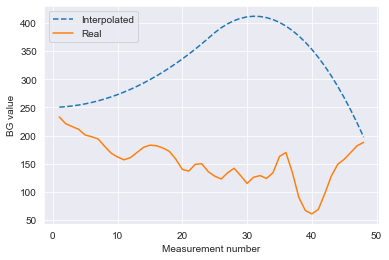

In [410]:
plt.plot(range(1, interpolated.shape[0] + 1), interpolated, label = "Interpolated", linestyle="--")
plt.plot(range(1, interpolated.shape[0] + 1), df_glucose_patient_test_12["Measurement"], label = "Real")
plt.xlabel("Measurement number")
plt.ylabel("BG value")
plt.legend()
plt.show()

# 1/4 day

In [411]:
df_glucose_patient_6 = df_glucose_patient.copy()
df_glucose_patient_test_6 = \
    df_glucose_patient[(df_glucose_patient["Measurement_date"] == "2020-01-29") & (
                df_glucose_patient["Measurement_time"] < "06:00:00")]
df_glucose_patient_test_6



,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
1914421,LIB193367,2020-01-29,00:00:00,233,2020-01-29 00:00:00,2020-01-28 23:44:00,16.000000,250.000000,17.000000
1914422,LIB193367,2020-01-29,00:15:00,221,2020-01-29 00:15:00,2020-01-29 00:00:00,15.000000,233.000000,12.000000
1914423,LIB193367,2020-01-29,00:30:00,216,2020-01-29 00:30:00,2020-01-29 00:15:00,15.000000,221.000000,5.000000
1914424,LIB193367,2020-01-29,00:45:00,211,2020-01-29 00:45:00,2020-01-29 00:30:00,15.000000,216.000000,5.000000
1914425,LIB193367,2020-01-29,01:00:00,201,2020-01-29 01:00:00,2020-01-29 00:45:00,15.000000,211.000000,10.000000
1914426,LIB193367,2020-01-29,01:15:00,198,2020-01-29 01:15:00,2020-01-29 01:00:00,15.000000,201.000000,3.000000
1914427,LIB193367,2020-01-29,01:30:00,194,2020-01-29 01:30:00,2020-01-29 01:15:00,15.000000,198.000000,4.000000
1914428,LIB193367,2020-01-29,01:45:00,181,2020-01-29 01:45:00,2020-01-29 01:30:00,15.000000,194.000000,13.000000
1914429,LIB193367,2020-01-29,02:00:00,169,2020-01-29 02:00:00,2020-01-29 01:45:00,15.000000,181.000000,12.000000
1914430,LIB193367,2020-01-29,02:15:00,162,2020-01-29 02:15:00,2020-01-29 02:00:00,15.000000,169.000000,7.000000


In [412]:
df_glucose_patient_6["Measurement"].loc[(df_glucose_patient_6["Measurement_date"] == "2020-01-29") & (
            df_glucose_patient_6["Measurement_time"] < "06:00:00")] = np.nan
df_glucose_patient_6

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
1914306,LIB193367,2020-01-27,19:06:00,216.000000,2020-01-27 19:06:00,2020-01-27 18:51:00,15.000000,213.000000,3.000000
1914307,LIB193367,2020-01-27,19:22:00,207.000000,2020-01-27 19:22:00,2020-01-27 19:06:00,16.000000,216.000000,9.000000
1914308,LIB193367,2020-01-27,19:37:00,216.000000,2020-01-27 19:37:00,2020-01-27 19:22:00,15.000000,207.000000,9.000000
1914309,LIB193367,2020-01-27,19:52:00,222.000000,2020-01-27 19:52:00,2020-01-27 19:37:00,15.000000,216.000000,6.000000
1914310,LIB193367,2020-01-27,20:07:00,203.000000,2020-01-27 20:07:00,2020-01-27 19:52:00,15.000000,222.000000,19.000000
...,...,...,...,...,...,...,...,...,...
1991225,LIB193367,2022-03-15,11:46:00,283.000000,2022-03-15 11:46:00,2022-03-15 11:31:00,15.000000,263.000000,20.000000
1991226,LIB193367,2022-03-15,12:01:00,277.000000,2022-03-15 12:01:00,2022-03-15 11:46:00,15.000000,283.000000,6.000000
1991227,LIB193367,2022-03-15,12:16:00,240.000000,2022-03-15 12:16:00,2022-03-15 12:01:00,15.000000,277.000000,37.000000
1991228,LIB193367,2022-03-15,12:31:00,199.000000,2022-03-15 12:31:00,2022-03-15 12:16:00,15.000000,240.000000,41.000000


In [413]:
df_glucose_patient_6["Measurement"] = df_glucose_patient_6["Measurement"].interpolate(method="polynomial", order=2)
df_glucose_patient_6[(df_glucose_patient_6["Measurement_date"] == "2020-01-29") & (
            df_glucose_patient_6["Measurement_time"] < "06:00:00")]

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
1914421,LIB193367,2020-01-29,00:00:00,249.703053,2020-01-29 00:00:00,2020-01-28 23:44:00,16.000000,250.000000,17.000000
1914422,LIB193367,2020-01-29,00:15:00,248.940245,2020-01-29 00:15:00,2020-01-29 00:00:00,15.000000,233.000000,12.000000
1914423,LIB193367,2020-01-29,00:30:00,247.711575,2020-01-29 00:30:00,2020-01-29 00:15:00,15.000000,221.000000,5.000000
1914424,LIB193367,2020-01-29,00:45:00,246.017044,2020-01-29 00:45:00,2020-01-29 00:30:00,15.000000,216.000000,5.000000
1914425,LIB193367,2020-01-29,01:00:00,243.856650,2020-01-29 01:00:00,2020-01-29 00:45:00,15.000000,211.000000,10.000000
1914426,LIB193367,2020-01-29,01:15:00,241.230396,2020-01-29 01:15:00,2020-01-29 01:00:00,15.000000,201.000000,3.000000
1914427,LIB193367,2020-01-29,01:30:00,238.138280,2020-01-29 01:30:00,2020-01-29 01:15:00,15.000000,198.000000,4.000000
1914428,LIB193367,2020-01-29,01:45:00,234.580302,2020-01-29 01:45:00,2020-01-29 01:30:00,15.000000,194.000000,13.000000
1914429,LIB193367,2020-01-29,02:00:00,230.556463,2020-01-29 02:00:00,2020-01-29 01:45:00,15.000000,181.000000,12.000000
1914430,LIB193367,2020-01-29,02:15:00,226.066762,2020-01-29 02:15:00,2020-01-29 02:00:00,15.000000,169.000000,7.000000


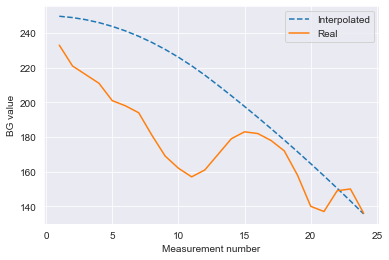

In [414]:
interpolated = df_glucose_patient_6.loc[(df_glucose_patient_6["Measurement_date"] == "2020-01-29") & (
            df_glucose_patient_6["Measurement_time"] < "06:00:00"), "Measurement"]

plt.plot(range(1, interpolated.shape[0] + 1), interpolated, label = "Interpolated", linestyle="--")
plt.plot(range(1, interpolated.shape[0] + 1), df_glucose_patient_test_6["Measurement"], label = "Real")
plt.xlabel("Measurement number")
plt.ylabel("BG value")
plt.legend()
plt.show()

# 1/8 day

In [415]:
df_glucose_patient_3 = df_glucose_patient.copy()
df_glucose_patient_test_3 = \
    df_glucose_patient[(df_glucose_patient["Measurement_date"] == "2020-01-29") & (
            df_glucose_patient["Measurement_time"] < "03:00:00")]
df_glucose_patient_test_3

,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
1914421,LIB193367,2020-01-29,00:00:00,233,2020-01-29 00:00:00,2020-01-28 23:44:00,16.000000,250.000000,17.000000
1914422,LIB193367,2020-01-29,00:15:00,221,2020-01-29 00:15:00,2020-01-29 00:00:00,15.000000,233.000000,12.000000
1914423,LIB193367,2020-01-29,00:30:00,216,2020-01-29 00:30:00,2020-01-29 00:15:00,15.000000,221.000000,5.000000
1914424,LIB193367,2020-01-29,00:45:00,211,2020-01-29 00:45:00,2020-01-29 00:30:00,15.000000,216.000000,5.000000
1914425,LIB193367,2020-01-29,01:00:00,201,2020-01-29 01:00:00,2020-01-29 00:45:00,15.000000,211.000000,10.000000
1914426,LIB193367,2020-01-29,01:15:00,198,2020-01-29 01:15:00,2020-01-29 01:00:00,15.000000,201.000000,3.000000
1914427,LIB193367,2020-01-29,01:30:00,194,2020-01-29 01:30:00,2020-01-29 01:15:00,15.000000,198.000000,4.000000
1914428,LIB193367,2020-01-29,01:45:00,181,2020-01-29 01:45:00,2020-01-29 01:30:00,15.000000,194.000000,13.000000
1914429,LIB193367,2020-01-29,02:00:00,169,2020-01-29 02:00:00,2020-01-29 01:45:00,15.000000,181.000000,12.000000
1914430,LIB193367,2020-01-29,02:15:00,162,2020-01-29 02:15:00,2020-01-29 02:00:00,15.000000,169.000000,7.000000


In [416]:
df_glucose_patient_3["Measurement"].loc[(df_glucose_patient_3["Measurement_date"] == "2020-01-29") & (
        df_glucose_patient_3["Measurement_time"] < "03:00:00")] = np.nan
df_glucose_patient_3


,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
1914306,LIB193367,2020-01-27,19:06:00,216.000000,2020-01-27 19:06:00,2020-01-27 18:51:00,15.000000,213.000000,3.000000
1914307,LIB193367,2020-01-27,19:22:00,207.000000,2020-01-27 19:22:00,2020-01-27 19:06:00,16.000000,216.000000,9.000000
1914308,LIB193367,2020-01-27,19:37:00,216.000000,2020-01-27 19:37:00,2020-01-27 19:22:00,15.000000,207.000000,9.000000
1914309,LIB193367,2020-01-27,19:52:00,222.000000,2020-01-27 19:52:00,2020-01-27 19:37:00,15.000000,216.000000,6.000000
1914310,LIB193367,2020-01-27,20:07:00,203.000000,2020-01-27 20:07:00,2020-01-27 19:52:00,15.000000,222.000000,19.000000
...,...,...,...,...,...,...,...,...,...
1991225,LIB193367,2022-03-15,11:46:00,283.000000,2022-03-15 11:46:00,2022-03-15 11:31:00,15.000000,263.000000,20.000000
1991226,LIB193367,2022-03-15,12:01:00,277.000000,2022-03-15 12:01:00,2022-03-15 11:46:00,15.000000,283.000000,6.000000
1991227,LIB193367,2022-03-15,12:16:00,240.000000,2022-03-15 12:16:00,2022-03-15 12:01:00,15.000000,277.000000,37.000000
1991228,LIB193367,2022-03-15,12:31:00,199.000000,2022-03-15 12:31:00,2022-03-15 12:16:00,15.000000,240.000000,41.000000


In [417]:
df_glucose_patient_3["Measurement"] = df_glucose_patient_3["Measurement"].interpolate(method="polynomial", order=2)
df_glucose_patient_3[(df_glucose_patient_3["Measurement_date"] == "2020-01-29") & (
        df_glucose_patient_3["Measurement_time"] < "03:00:00")]


,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
1914421,LIB193367,2020-01-29,00:00:00,248.078693,2020-01-29 00:00:00,2020-01-28 23:44:00,16.000000,250.000000,17.000000
1914422,LIB193367,2020-01-29,00:15:00,243.788467,2020-01-29 00:15:00,2020-01-29 00:00:00,15.000000,233.000000,12.000000
1914423,LIB193367,2020-01-29,00:30:00,237.129323,2020-01-29 00:30:00,2020-01-29 00:15:00,15.000000,221.000000,5.000000
1914424,LIB193367,2020-01-29,00:45:00,228.101261,2020-01-29 00:45:00,2020-01-29 00:30:00,15.000000,216.000000,5.000000
1914425,LIB193367,2020-01-29,01:00:00,216.704281,2020-01-29 01:00:00,2020-01-29 00:45:00,15.000000,211.000000,10.000000
1914426,LIB193367,2020-01-29,01:15:00,202.938383,2020-01-29 01:15:00,2020-01-29 01:00:00,15.000000,201.000000,3.000000
1914427,LIB193367,2020-01-29,01:30:00,187.571333,2020-01-29 01:30:00,2020-01-29 01:15:00,15.000000,198.000000,4.000000
1914428,LIB193367,2020-01-29,01:45:00,175.209733,2020-01-29 01:45:00,2020-01-29 01:30:00,15.000000,194.000000,13.000000
1914429,LIB193367,2020-01-29,02:00:00,166.621352,2020-01-29 02:00:00,2020-01-29 01:45:00,15.000000,181.000000,12.000000
1914430,LIB193367,2020-01-29,02:15:00,161.806188,2020-01-29 02:15:00,2020-01-29 02:00:00,15.000000,169.000000,7.000000


In [418]:
interpolated = df_glucose_patient_3.loc[(df_glucose_patient_3["Measurement_date"] == "2020-01-29") & (
        df_glucose_patient_3["Measurement_time"] < "03:00:00"), "Measurement"]

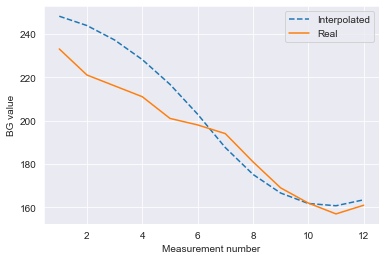

In [419]:
plt.plot(range(1, interpolated.shape[0] + 1), interpolated, label = "Interpolated", linestyle="--")
plt.plot(range(1, interpolated.shape[0] + 1), df_glucose_patient_test_3["Measurement"], label = "Real")
plt.xlabel("Measurement number")
plt.ylabel("BG value")
plt.legend()
plt.show()

----------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------
# Same experiment for other patient

In [426]:
df_glucose_patient = df_glucose_lag[df_glucose_lag["Patient_ID"] == 'LIB193307']
df_glucose_patient


,Patient_ID,Measurement_date,Measurement_time,Measurement,t,t-1,Minutes_diff,Measurement-1,Measurement_diff
678729,LIB193307,2018-11-04,21:25:00,247,2018-11-04 21:25:00,2018-11-04 21:10:00,15.000000,203.000000,44.000000
678730,LIB193307,2018-11-04,21:40:00,294,2018-11-04 21:40:00,2018-11-04 21:25:00,15.000000,247.000000,47.000000
678731,LIB193307,2018-11-04,21:55:00,281,2018-11-04 21:55:00,2018-11-04 21:40:00,15.000000,294.000000,13.000000
678732,LIB193307,2018-11-04,22:10:00,263,2018-11-04 22:10:00,2018-11-04 21:55:00,15.000000,281.000000,18.000000
678733,LIB193307,2018-11-04,22:25:00,269,2018-11-04 22:25:00,2018-11-04 22:10:00,15.000000,263.000000,6.000000
...,...,...,...,...,...,...,...,...,...
782781,LIB193307,2022-03-17,19:14:00,108,2022-03-17 19:14:00,2022-03-17 18:59:00,15.000000,128.000000,20.000000
782782,LIB193307,2022-03-17,19:29:00,84,2022-03-17 19:29:00,2022-03-17 19:14:00,15.000000,108.000000,24.000000
782783,LIB193307,2022-03-17,19:44:00,72,2022-03-17 19:44:00,2022-03-17 19:29:00,15.000000,84.000000,12.000000
782784,LIB193307,2022-03-17,19:59:00,67,2022-03-17 19:59:00,2022-03-17 19:44:00,15.000000,72.000000,5.000000


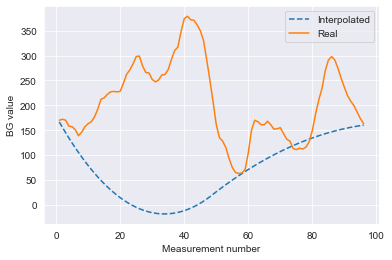

In [427]:
# 1 complete day
df_glucose_patient_24 = df_glucose_patient.copy()
df_glucose_patient_test_24 = df_glucose_patient[df_glucose_patient["Measurement_date"] == "2018-11-05"]
df_glucose_patient_24["Measurement"].loc[df_glucose_patient_24["Measurement_date"] == "2018-11-05"] = np.nan
df_glucose_patient_24["Measurement"] = df_glucose_patient_24["Measurement"].interpolate(method="polynomial", order=2)
df_glucose_patient_24[df_glucose_patient_24["Measurement_date"] == "2018-11-05"]
interpolated = df_glucose_patient_24.loc[df_glucose_patient_24["Measurement_date"] == "2018-11-05", "Measurement"]

plt.plot(range(1, interpolated.shape[0] + 1), interpolated, label="Interpolated", linestyle="--")
plt.plot(range(1, interpolated.shape[0] + 1), df_glucose_patient_test_24["Measurement"], label="Real")
plt.xlabel("Measurement number")
plt.ylabel("BG value")
plt.legend()
plt.show()


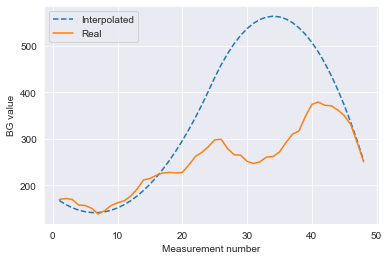

In [428]:
# 1/2 day
df_glucose_patient_12 = df_glucose_patient.copy()
df_glucose_patient_test_12 = \
    df_glucose_patient[(df_glucose_patient["Measurement_date"] == "2018-11-05") & (
                df_glucose_patient["Measurement_time"] < "12:00:00")]


df_glucose_patient_12["Measurement"].loc[(df_glucose_patient_12["Measurement_date"] == "2018-11-05") & (
            df_glucose_patient_12["Measurement_time"] < "12:00:00")] = np.nan


df_glucose_patient_12["Measurement"] = df_glucose_patient_12["Measurement"].interpolate(method="polynomial", order=2)
df_glucose_patient_12[(df_glucose_patient_12["Measurement_date"] == "2018-11-05") & (
            df_glucose_patient_12["Measurement_time"] < "12:00:00")]

interpolated = df_glucose_patient_12.loc[(df_glucose_patient_12["Measurement_date"] == "2018-11-05") & (
            df_glucose_patient_12["Measurement_time"] < "12:00:00"), "Measurement"]

plt.plot(range(1, interpolated.shape[0] + 1), interpolated, label="Interpolated", linestyle="--")
plt.plot(range(1, interpolated.shape[0] + 1), df_glucose_patient_test_12["Measurement"], label="Real")
plt.xlabel("Measurement number")
plt.ylabel("BG value")
plt.legend()
plt.show()


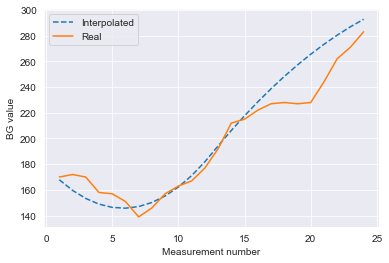

In [429]:
# 1/4 day
df_glucose_patient_6 = df_glucose_patient.copy()
df_glucose_patient_test_6 = \
    df_glucose_patient[(df_glucose_patient["Measurement_date"] == "2018-11-05") & (
            df_glucose_patient["Measurement_time"] < "06:00:00")]
df_glucose_patient_test_6

df_glucose_patient_6["Measurement"].loc[(df_glucose_patient_6["Measurement_date"] == "2018-11-05") & (
        df_glucose_patient_6["Measurement_time"] < "06:00:00")] = np.nan
df_glucose_patient_6
df_glucose_patient_6["Measurement"] = df_glucose_patient_6["Measurement"].interpolate(method="polynomial", order=2)
df_glucose_patient_6[(df_glucose_patient_6["Measurement_date"] == "2018-11-05") & (
        df_glucose_patient_6["Measurement_time"] < "06:00:00")]
interpolated = df_glucose_patient_6.loc[(df_glucose_patient_6["Measurement_date"] == "2018-11-05") & (
        df_glucose_patient_6["Measurement_time"] < "06:00:00"), "Measurement"]

plt.plot(range(1, interpolated.shape[0] + 1), interpolated, label="Interpolated", linestyle="--")
plt.plot(range(1, interpolated.shape[0] + 1), df_glucose_patient_test_6["Measurement"], label="Real")
plt.xlabel("Measurement number")
plt.ylabel("BG value")
plt.legend()
plt.show()


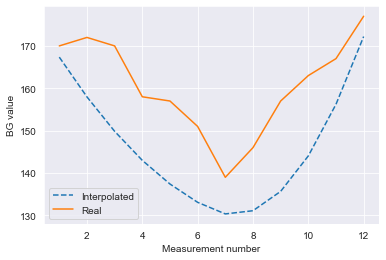

In [430]:
# 1/8 day
df_glucose_patient_3 = df_glucose_patient.copy()
df_glucose_patient_test_3 = \
    df_glucose_patient[(df_glucose_patient["Measurement_date"] == "2018-11-05") & (
            df_glucose_patient["Measurement_time"] < "03:00:00")]
df_glucose_patient_test_3
df_glucose_patient_3["Measurement"].loc[(df_glucose_patient_3["Measurement_date"] == "2018-11-05") & (
        df_glucose_patient_3["Measurement_time"] < "03:00:00")] = np.nan
df_glucose_patient_3

df_glucose_patient_3["Measurement"] = df_glucose_patient_3["Measurement"].interpolate(method="polynomial", order=2)
df_glucose_patient_3[(df_glucose_patient_3["Measurement_date"] == "2018-11-05") & (
        df_glucose_patient_3["Measurement_time"] < "03:00:00")]

interpolated = df_glucose_patient_3.loc[(df_glucose_patient_3["Measurement_date"] == "2018-11-05") & (
        df_glucose_patient_3["Measurement_time"] < "03:00:00"), "Measurement"]
plt.plot(range(1, interpolated.shape[0] + 1), interpolated, label="Interpolated", linestyle="--")
plt.plot(range(1, interpolated.shape[0] + 1), df_glucose_patient_test_3["Measurement"], label="Real")
plt.xlabel("Measurement number")
plt.ylabel("BG value")
plt.legend()
plt.show()